In [2]:
from qiskit import QuantumRegister
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit import ClassicalRegister,  transpile
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit import BasicAer
import random
import math
from qiskit import BasicAer, execute
import statistics
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

In [3]:
def nonlocal_gate(qc, ctrl_qubit, target_qubit, comm_1, comm_2, theta,p):
    k = 1
    n = 0
    while k!=0:
        p_random = np.average(random.sample(range(1, 100), 3))/100
        n = n+1
        if p>p_random:
            qc.h(comm_1)
            qc.cx(comm_1,comm_2)
            k=0
    qc.cx(ctrl_qubit,comm_1)
    qc.measure(comm_1,0)
    qc.x(comm_2).c_if(cr[0], 1)
    qc.cu(theta,0,0,0,comm_2, target_qubit)
    qc.h(comm_2)
    qc.measure(comm_2,1)
    qc.z(ctrl_qubit).c_if(cr[1], 1)
    qc.reset(qr[7])
    qc.reset(qr[8])
    return qc,n

Cost function is 8.701000000000001e-05
Time taken for the quantum circuit 7.91e-06 s
Number of steps for entanglement generation is 3
The implementation has been completed


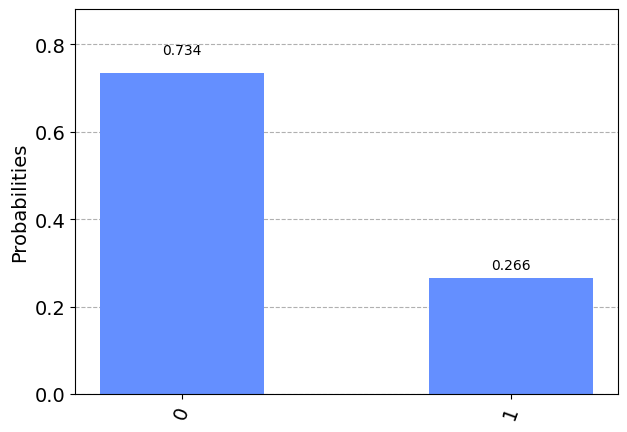

In [9]:
qr = QuantumRegister(9,'a')
cr = ClassicalRegister(2,'creg')
qc = QuantumCircuit(qr,cr)
num_shots = 10000
dist = 0.1
latt = 20
c = 2*1e5
pc = 0.9
p = 0.5*(pc**2)* math.exp(-dist/latt)
t_meas = 1e-7
t_cnot = 1e-7
t_cu = 1e-7
t_local = 1e-8
theta = [np.pi/8, np.pi/4, np.pi/2, -np.pi/4, np.pi/2, np.pi, np.pi/2, np.pi/2]
for i in range(0,7):
    qc.ry(theta[i],qr[i])
n_turns = 0
for i in range(0,6):
    qc,n = nonlocal_gate(qc, qr[i], qr[6], qr[7], qr[8],theta[i],p)
    n_turns = n_turns+n
qc.measure(6,0)
job = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=num_shots) 
hist = job.result().get_counts()
a_0 = []
a_1 = []
key = list(hist.keys())
val = list(hist.values())
for i in range(len(key)):
    if '1' in key[i][1]:
        a_1.append(val[i])
    elif '0' in key[i][1]:
        a_0.append(val[i])
hist_0={}
hist_0['0'] = sum(a_0)
hist_0['1'] = sum(a_1) 
gates = dict(qc.count_ops())
num_1 = []
num_2 = []
num_3 = []
for key in gates.keys():
    if key in ['h','x','y','z','ry','rx','rz','u']:
        num_1.append(gates[key])
    elif key in ['cx','cz','cu']:
        num_2.append(gates[key])
    elif key in ['measure']:
        num_3.append(gates[key])
num_1 = sum(num_1)
num_2 = sum(num_2)
num_3 = sum(num_3)
time_qc = (num_1*t_local + num_2*t_cu + num_3*t_meas)+3*(n*dist/c)
num_qubits = 11
cost_function = num_qubits*time_qc
print("Cost function is",cost_function)
print("Time taken for the quantum circuit", time_qc, "s")
print("Number of steps for entanglement generation is",n)
print("The implementation has been completed")
plot_histogram(hist_0)

Cost function is 0.00013651
Time taken for the quantum circuit 1.2410000000000001e-05 s
Number of steps for entanglement generation is 6
The implementation has been completed
The average fidelity of the state obtained is  0.996376387635678


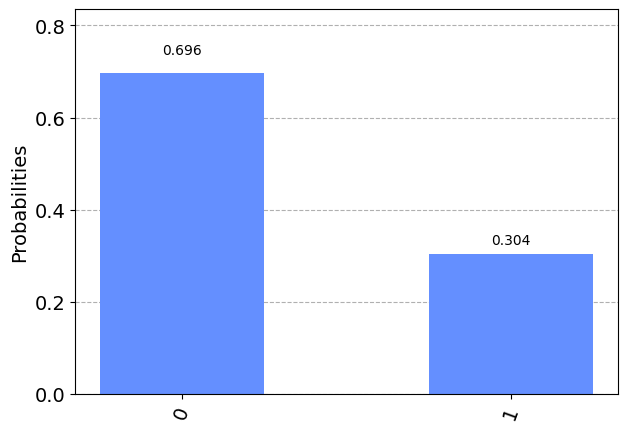

In [10]:
p1Q = 0.01 #single qubit gate error
p2Q = 0.01 #two qubit gate error
def nonlocal_gate(qc, ctrl_qubit, target_qubit, comm_1, comm_2, theta,p):
    k = 1
    n = 0
    while k!=0:
        p_random = np.average(random.sample(range(1, 100), 3))/100
        n = n+1
        if p>p_random:
            qc.h(comm_1)
            qc.cx(comm_1,comm_2)
            k=0
    qc.cx(ctrl_qubit,comm_1)
    qc.measure(comm_1,0)
    qc.x(comm_2).c_if(cr[0], 1)
    qc.cu(theta,0,0,0,comm_2, target_qubit)
    qc.h(comm_2)
    qc.measure(comm_2,1)
    qc.z(ctrl_qubit).c_if(cr[1], 1)
    qc.reset(qr[7])
    qc.reset(qr[8])
    return qc,n

qr = QuantumRegister(9,'a')
cr = ClassicalRegister(2,'creg')
qc = QuantumCircuit(qr,cr)
theta = [np.pi/8, np.pi/4, np.pi/2, -np.pi/4, np.pi/2, np.pi, np.pi/2, np.pi/2]
for i in range(0,7):
    qc.ry(theta[i],qr[i])
n_turns = 0
for i in range(0,6):
    qc,n = nonlocal_gate(qc, qr[i], qr[6], qr[7], qr[8],theta[i],p)
    n_turns = n_turns+n
qc.measure(6,0)
error_1 = noise.depolarizing_error(p1Q, 1)
error_2 = noise.depolarizing_error(p2Q, 2)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['x','z','h','ry'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx','cu'])
error_gate1 = pauli_error([('X',p2Q), ('I', 1 - p2Q)])
error_gate2 = error_gate1.tensor(error_gate1)
error_reset = pauli_error([('X', p1Q), ('I', 1 - p1Q)])
error_meas = pauli_error([('X',p1Q), ('I', 1 - p1Q)])
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
basis_gates = noise_model.basis_gates
result = execute(qc, Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model, shots=num_shots).result().get_counts(0)
a_0 = []
a_1 = []
key = list(result.keys())
val = list(result.values())
for i in range(len(key)):
    if '1' in key[i][1]:
        a_1.append(val[i])
    elif '0' in key[i][1]:
        a_0.append(val[i])
hist_1={}
hist_1['0'] = sum(a_0)
hist_1['1'] = sum(a_1) 
prob_20 = hist_1['0']/num_shots
prob_21 = hist_1['1']/num_shots
gates = dict(qc.count_ops())
num_1 = []
num_2 = []
num_3 = []
for key in gates.keys():
    if key in ['h','x','y','z','ry','rx','rz','u']:
        num_1.append(gates[key])
    elif key in ['cx','cz','cu']:
        num_2.append(gates[key])
    elif key in ['measure']:
        num_3.append(gates[key])
num_1 = sum(num_1)
num_2 = sum(num_2)
num_3 = sum(num_3)
time_qc = (num_1*t_local + num_2*t_cu + num_3*t_meas)+3*(n*dist/c)
num_qubits = 11
cost_function = num_qubits*time_qc
print("Cost function is",cost_function)
print("Time taken for the quantum circuit", time_qc, "s")
print("Number of steps for entanglement generation is",n)
print("The implementation has been completed")
F = ((p_10*p_20) + (p_11*p_21) + 2*math.sqrt(p_10*p_11*p_20*p_21))**2
print("The average fidelity of the state obtained is ",F)
plot_histogram(hist_1)